# Digit recognition problems

In [5]:
import math
import numpy as np

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

import nn
from optim import SGDOptimizer

from supervised_learning import MyMLPClassifier
from dataset.load_data import sklearn_to_df, prepare_data_loader

from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [6]:
def prepare_data():
    X, Y = sklearn_to_df(load_digits())
    X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.33, random_state=42)
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_te = scaler.transform(X_te)

    print ("train_x's shape: " + str(X_tr.shape))
    print ("test_x's shape: " + str(X_te.shape))
    print ("train_y's shape: " + str(y_tr.shape))
    print ("test_y's shape: " + str(y_te.shape))
    print()
    
    return X_tr, X_te, y_tr, y_te

def prepare_trainer(model):
    optimizer = SGDOptimizer(model, learning_rate=0.1, regularization=0.01)
    loss_func = nn.CrossEntropyLoss()
    return optimizer, loss_func

def build_model(n_in, n_classes):
    np.random.seed(101)
    model = MyMLPClassifier(n_input=n_in, hiddens=[256, 128, 64], n_output=n_classes, activation='relu')   
    return model

In [7]:
def train():
    X, Xtest, y, ytest = prepare_data()
    n_in, n_class = X.shape[1], 10

    n_epoch = 220
    batch_size = 32

    model = build_model(n_in, n_class)
    optimizer, loss_func = prepare_trainer(model)

    model.info()

    pbar_train = tqdm(total=n_epoch, desc='Training', position=0)
    pbar_val = tqdm(total=n_epoch, desc='Validation', position=1)

    train_accuracies = []
    val_accuracies = []
    train_losses = []  
    val_losses = []    

    # Training loop
    for epoch in range(n_epoch):
        # Prepare the data loader for training data
        train_data_loader = prepare_data_loader(X, y, batch_size)
        
        # Initialize counters for tracking training progress
        step = 0
        total_loss, total_correct = 0, 0
        total_sample = 0

        # Training
        model.train() # Training mode                
        for batch_X, batch_y in train_data_loader:
            # forward pass: compute logits and loss
            batch_logit = model.forward(batch_X)        # output model: logit
            loss = loss_func.forward(batch_logit, batch_y)

            # backward pass and an optimization step
            optimizer.zero_grad()
            dout = loss_func.backward()
            model.backward(dout)
            optimizer.step()

            # log training progress
            step += 1
            total_loss += loss
            batch_yp = np.argmax(batch_logit, axis=1)   # logit --> label
            total_correct += np.sum(batch_yp == batch_y)
            total_sample += len(batch_y)

            # Print and update progress bar
            pbar_train.set_description(f"Traning: epoch {epoch}, step {step}, train_loss {total_loss/total_sample:.4f}, train_acc {total_correct/total_sample*100:.2f}%")
        
        pbar_train.update(1)    # Update the training progress bar for the completed epoch

        # Validation
        model.eval() # Validate mode
        val_data_loader = prepare_data_loader(Xtest, ytest, batch_size)

        val_step = 0
        val_total_loss, val_total_correct = 0, 0
        val_total_sample = 0

        for val_batch_X, val_batch_y in val_data_loader:
            # forward pass: compute logits and loss
            val_batch_logit = model.forward(val_batch_X)        # output model: logit
            val_loss = loss_func.forward(val_batch_logit, val_batch_y)

            # log training progress
            val_step += 1
            val_total_loss += val_loss
            val_batch_yp = np.argmax(val_batch_logit, axis=1)   # logit --> label
            val_total_correct += np.sum(val_batch_yp == val_batch_y)
            val_total_sample += len(val_batch_y)


            # Print and update progress bar
            pbar_val.set_description(f"Validation: epoch {epoch}, step {val_step}, val_loss {val_total_loss/val_total_sample:.4f}, val_acc {val_total_correct/val_total_sample*100:.2f}%")
        
        pbar_val.update(1)   # Update the validation progress bar for the completed epoch
        
        
        # Save training and validation metrics
        train_accuracies.append(total_correct/total_sample * 100)
        train_losses.append(total_loss / total_sample) 
        val_accuracies.append(val_total_correct/val_total_sample * 100)
        val_losses.append(val_total_loss / val_total_sample)   

    # Close the progress bars
    pbar_train.close()
    pbar_val.close()

    # Plotting
    epochs_range = range(1, n_epoch + 1)

    plt.figure(figsize=(12, 4))

    # Plot Training Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Train/Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Train/Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    ypred = np.argmax(model.forward(Xtest), axis=1)
    print(classification_report(ytest, ypred))
    print(confusion_matrix(ytest, ypred))
    
    # skmodel = MLPClassifier()
    # skmodel.fit(X, y)

    #  # Print information about the trained scikit-learn MLPClassifier
    # print("\nScikit-learn MLPClassifier Info:")
    # print("Number of layers:", skmodel.n_layers_)
    # print("Number of neurons in each layer:", skmodel.hidden_layer_sizes)
    # print("Number of output classes:", skmodel.n_outputs_)
    # print("Activation function:", skmodel.activation)
    # print("Solver:", skmodel.solver)
    # print("Learning rate:", skmodel.learning_rate)
    # print("Initial learning rate:", skmodel.learning_rate_init)
    # print("Batch size:", skmodel.batch_size)
    # print("Maximum number of iterations:", skmodel.max_iter)
    # # Add more model-specific information as needed

    # ypred = skmodel.predict(Xtest)
    # print("\nClassification report of sklearn's model:\n", classification_report(ytest, ypred))

train_x's shape: (1203, 64)
test_x's shape: (594, 64)
train_y's shape: (1203,)
test_y's shape: (594,)

MyMLPClassifier(
(linear): Linear(in_features=64, out_features=256, bias=True)
(relu): ReLU()
(linear): Linear(in_features=256, out_features=128, bias=True)
(relu): ReLU()
(linear): Linear(in_features=128, out_features=64, bias=True)
(relu): ReLU()
(linear): Linear(in_features=64, out_features=10, bias=True)
)


Training:   0%|          | 0/220 [00:00<?, ?it/s]

Validation:   0%|          | 0/220 [00:00<?, ?it/s]

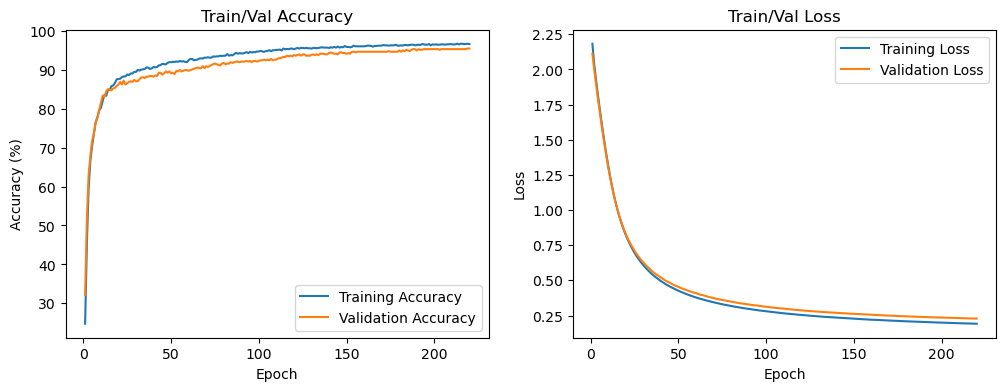

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.92      0.87      0.90        55
           2       0.98      1.00      0.99        52
           3       0.95      0.96      0.96        56
           4       0.95      0.98      0.97        64
           5       0.97      0.95      0.96        73
           6       1.00      0.96      0.98        57
           7       0.98      0.98      0.98        62
           8       0.89      0.92      0.91        52
           9       0.91      0.91      0.91        68

    accuracy                           0.95       594
   macro avg       0.95      0.96      0.95       594
weighted avg       0.95      0.95      0.95       594

[[55  0  0  0  0  0  0  0  0  0]
 [ 0 48  1  0  2  0  0  0  2  2]
 [ 0  0 52  0  0  0  0  0  0  0]
 [ 0  0  0 54  0  0  0  0  1  1]
 [ 0  1  0  0 63  0  0  0  0  0]
 [ 0  0  0  0  1 69  0  0  1  2]
 [ 1  0  0  0  0  0 55  0  1  0]
 [ 0  0  0

In [8]:
import time

if __name__ == "__main__":
    start_time = time.time()
    train()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining time: {elapsed_time} seconds")
